<a href="https://colab.research.google.com/github/bautista3383/Ventas_Retail/blob/main/Ventas_Retail_Final_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 0. Importando librerías ---
Sube tu archivo kaggle.json:


Saving kaggle.json to kaggle (3).json
Dataset URL: https://www.kaggle.com/datasets/tevecsystems/retail-sales-forecasting
License(s): CC-BY-NC-SA-4.0
retail-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  retail-sales-forecasting.zip
replace mock_kaggle.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: mock_kaggle.csv         
'kaggle (1).json'   kaggle.json			   sample_data
'kaggle (2).json'   mock_kaggle.csv
'kaggle (3).json'   retail-sales-forecasting.zip

--- 1. Carga y EDA Inicial ---
Dataset 'mock_kaggle.csv' cargado exitosamente.

Resumen estadístico inicial (df.describe()):
       venda  estoque  preco
count 937.00   937.00 937.00
mean   90.53  1608.26   1.59
std    80.68  1356.69   0.53
min     0.00     0.00   0.00
25%    33.00   794.00   1.29
50%    76.00  1348.00   1.39
75%   127.00  1964.00   1.89
max   542.00  7228.00   2.98

Valores nulos iniciales (df.isnull().sum()):
data       0
venda      0
esto

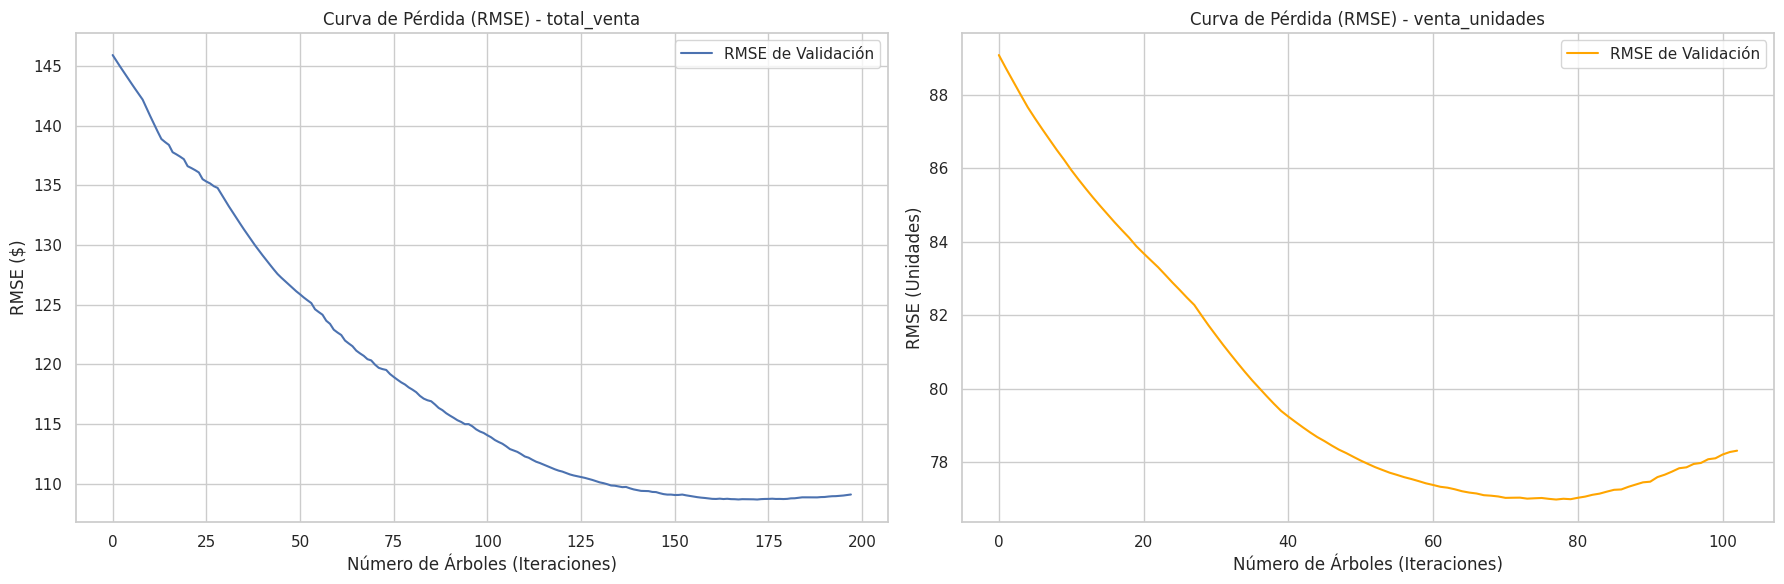

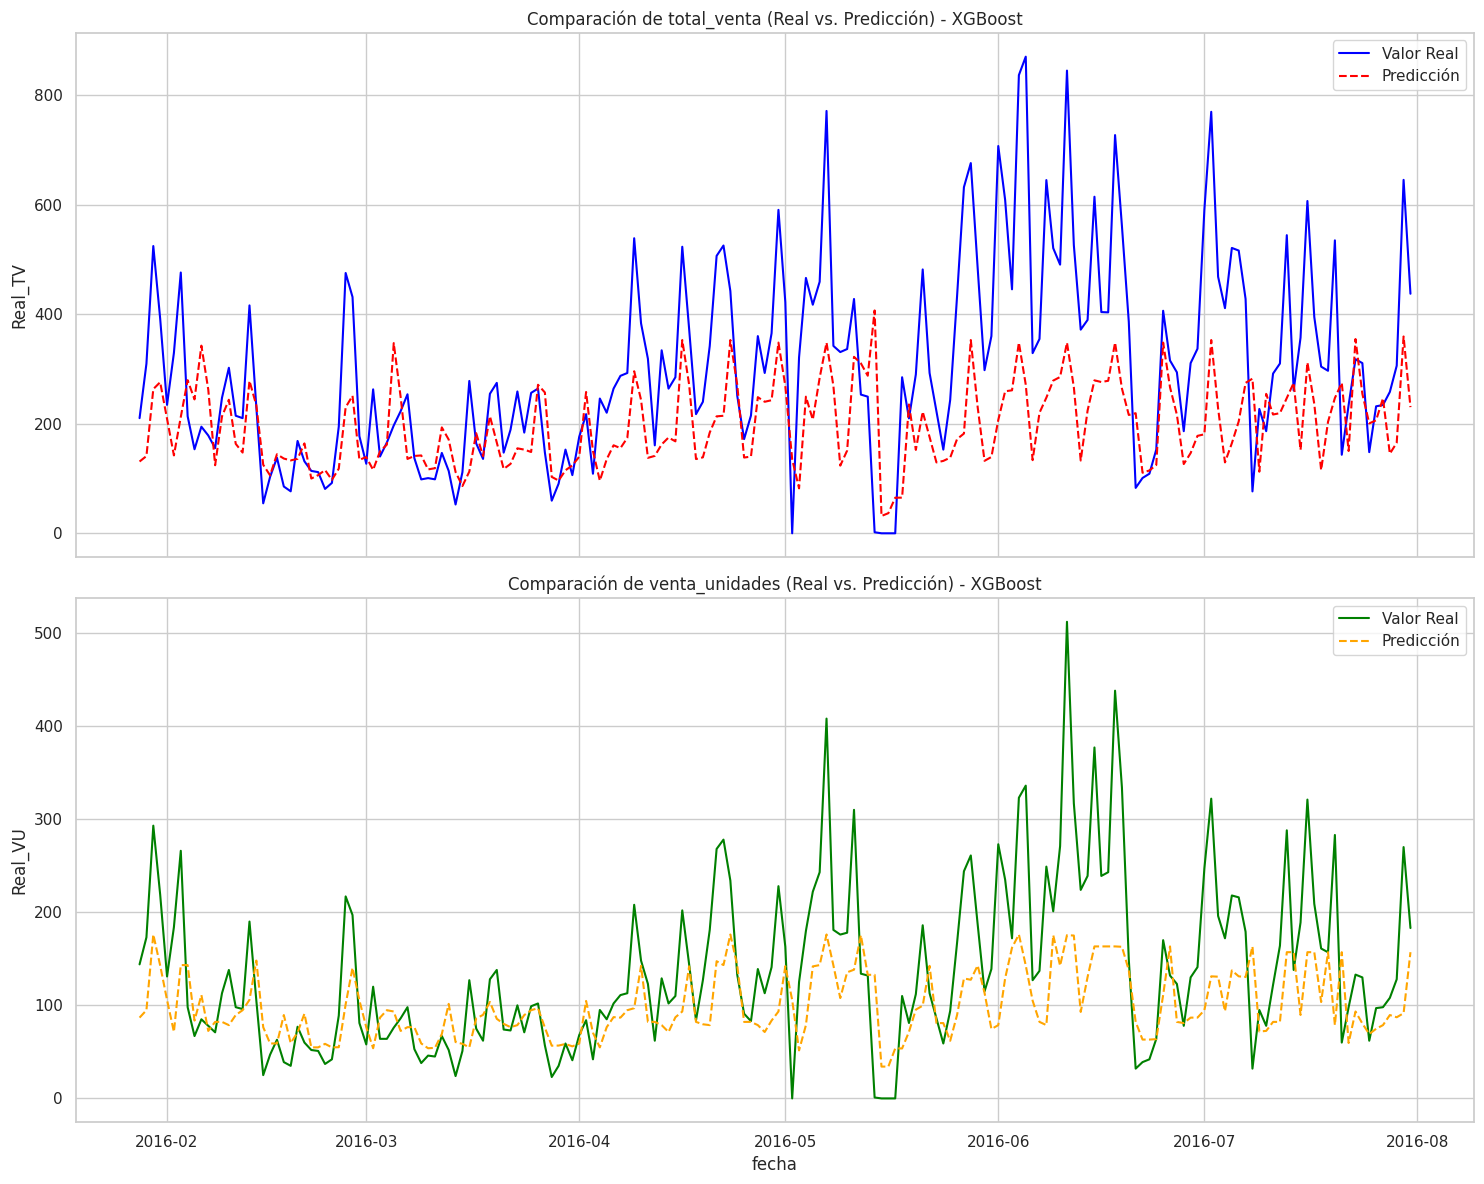

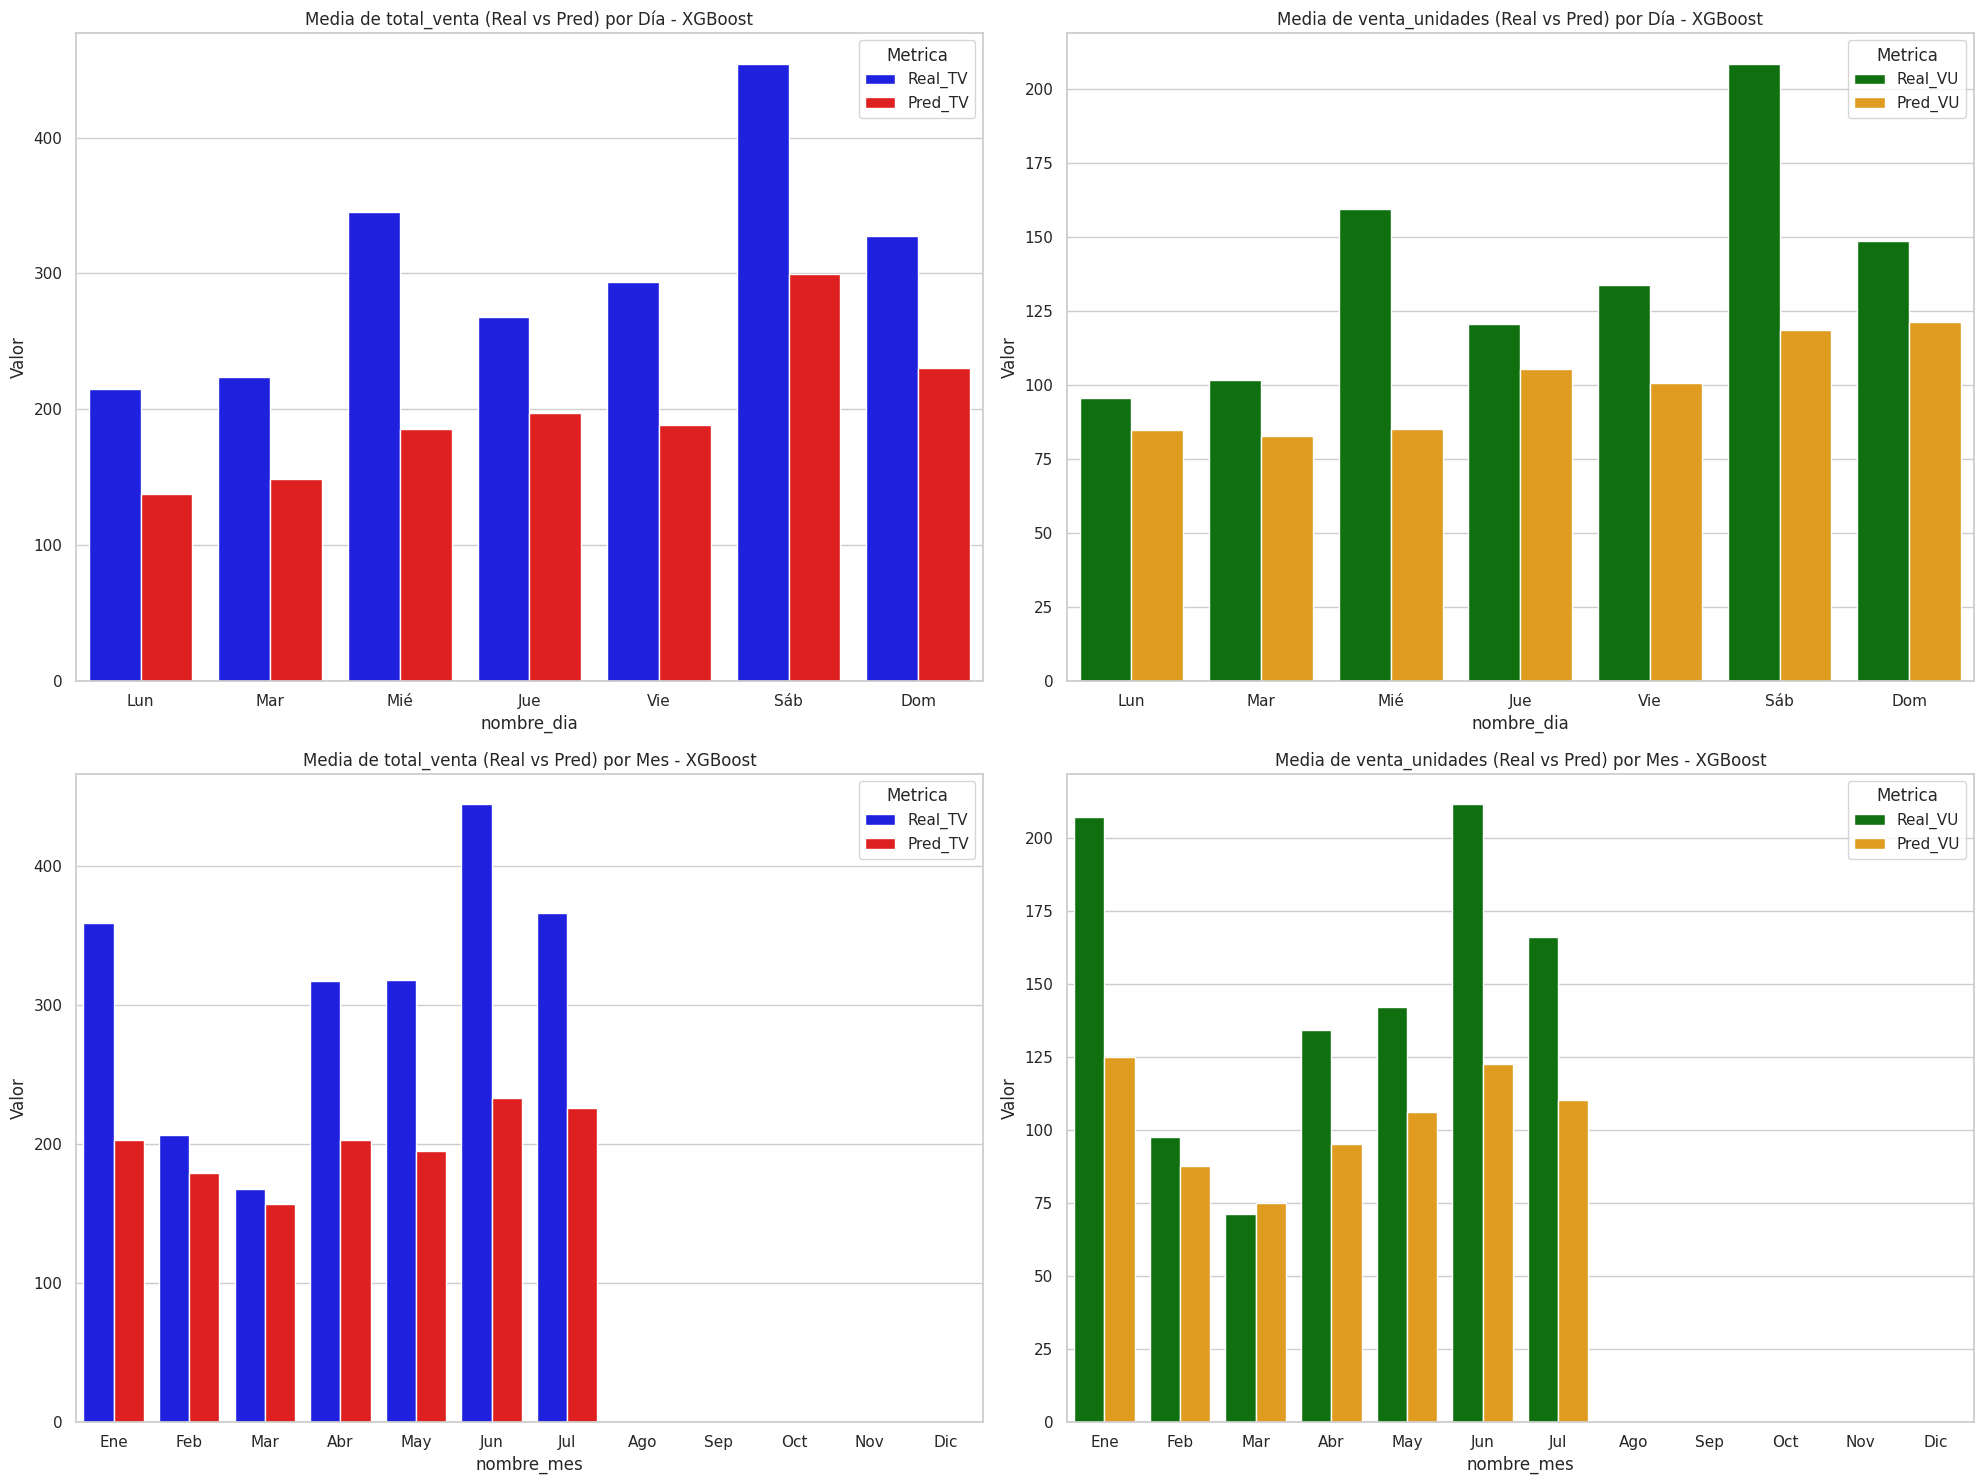

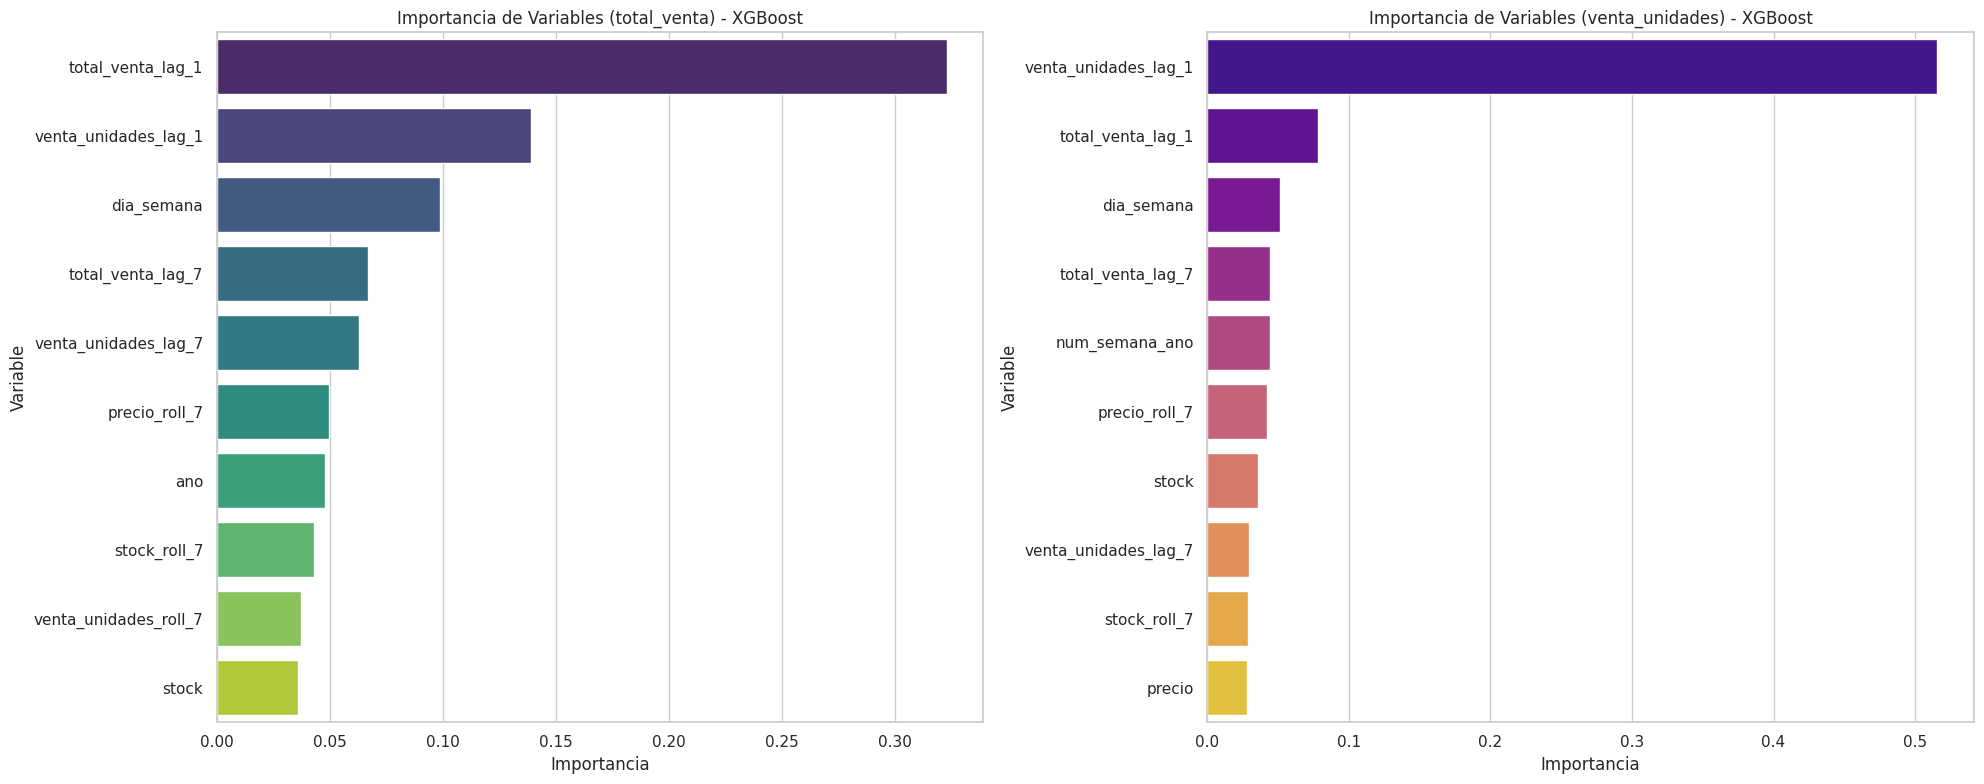

In [4]:
"""
Script Completo de Análisis y Modelado de Ventas
XGBoost Regressor (con Early Stopping)


Este script implementa un modelo XGBoost, considerado el estándar de la
industria para datos tabulares. Incluye una división de validación
para 'Early Stopping' (parada temprana) y genera las curvas de
pérdida (RMSE vs. Iteraciones).
"""

# --- 0. Importación de Librerías ---
print("--- 0. Importando librerías ---")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# --- NUEVO MODELO ---
from xgboost import XGBRegressor
# --- FIN NUEVO MODELO ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

# Se desactivan advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Se configura el estilo de las gráficas
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Instalación de la librería oficial de Kaggle (la -q es para que no muestre tanto texto)
!pip install kaggle -q
# Importación de la utilidad de archivos de Colab
from google.colab import files

# Diálogo para seleccionar el archivo
print('Sube tu archivo kaggle.json:')
files.upload()
# Creación de la carpeta oculta .kaggle donde la librería busca el API token
!mkdir -p ~/.kaggle

# Copia del archivo subido a esa carpeta
!cp kaggle.json ~/.kaggle/

# Asignación de los permisos correctos al archivo
!chmod 600 ~/.kaggle/kaggle.json
# Descarga del dataset usando su "slug": tevecsystems/retail-sales-forecasting
!kaggle datasets download -d tevecsystems/retail-sales-forecasting
# Descompresión del archivo .zip descargado
!unzip retail-sales-forecasting.zip
# Lista de los archivos para confirmar que 'mock_kaggle.csv' está ahí
!ls

# --- 1. Carga y EDA Inicial ---
print("\n--- 1. Carga y EDA Inicial ---")
try:
    # Se asume que el archivo 'mock_kaggle.csv' está cargado
    df = pd.read_csv('mock_kaggle.csv')
    print("Dataset 'mock_kaggle.csv' cargado exitosamente.")
except FileNotFoundError:
    print("Error: No se pudo encontrar el archivo 'mock_kaggle.csv'.")
    exit()

# Se muestra un resumen estadístico inicial
print("\nResumen estadístico inicial (df.describe()):")
print(df.describe())
print("\nValores nulos iniciales (df.isnull().sum()):")
print(df.isnull().sum())


# --- 2. Limpieza, Preprocesamiento y Creación de Variables ---
print("\n--- 2. Limpieza, Preprocesamiento y Creación de Variables ---")
df_clean = df.copy()

# Se renombran las columnas
columnas_nuevas = {
    'data': 'fecha',
    'venda': 'venta_unidades',
    'estoque': 'stock',
    'preco': 'precio'
}
df_clean = df_clean.rename(columns=columnas_nuevas)
print(f"Columnas renombradas a: {list(df_clean.columns)}")

# Se infiere el formato de fecha (Y-M-D)
df_clean['fecha'] = pd.to_datetime(df_clean['fecha'], errors='coerce')
df_clean = df_clean.dropna(subset=['fecha'])
df_clean = df_clean.sort_values(by='fecha').reset_index(drop=True)
print("Columna 'fecha' convertida a datetime exitosamente.")

# Se crea la columna 'total_venta'
df_clean['total_venta'] = df_clean['venta_unidades'] * df_clean['precio']
print("Columna 'total_venta' creada.")

# --- Manejo de Atípicos (Solo Negativos) ---
# Los modelos de árbol (como XGBoost) son robustos a outliers altos.
print("\nAjustando solo valores negativos a 0...")
columnas_numericas = ['venta_unidades', 'stock', 'precio', 'total_venta']
for col in columnas_numericas:
    df_clean[col] = np.clip(df_clean[col], 0, None)
print("Valores negativos (si los hubo) ajustados a 0.")

# --- Manejo de Valores Nulos ---
if df_clean.isnull().sum().any():
    df_clean = df_clean.ffill()
print("Valores nulos rellenados (si los hubo).")


# --- 3. Ingeniería de Variables de Tiempo ---
print("\n--- 3. Ingeniería de Variables de Tiempo ---")
df_clean['dia_semana'] = df_clean['fecha'].dt.dayofweek + 1
df_clean['num_semana_ano'] = df_clean['fecha'].dt.isocalendar().week.astype(int)
df_clean['mes'] = df_clean['fecha'].dt.month
df_clean['ano'] = df_clean['fecha'].dt.year

# Se crean nombres para los gráficos
nombres_meses = {1: 'Ene', 2: 'Feb', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dic'}
nombres_dias = {1: 'Lun', 2: 'Mar', 3: 'Mié', 4: 'Jue', 5: 'Vie', 6: 'Sáb', 7: 'Dom'}
df_clean['nombre_mes'] = df_clean['mes'].map(nombres_meses)
df_clean['nombre_dia'] = df_clean['dia_semana'].map(nombres_dias)
meses_ordenados = list(nombres_meses.values())
dias_ordenados = list(nombres_dias.values())
print("Variables de tiempo creadas.")


# --- 4. EDA Post-Limpieza y Visualización ---
print("\n--- 4. EDA Post-Limpieza y Visualización ---")
print("\nResumen estadístico post-limpieza (df_clean.describe()):")
print(df_clean.describe(include=[np.number]))


# --- 5. Ingeniería de Variables (Lags) para Modelado ---
print("\n--- 5. Ingeniería de Variables (Lags) para Modelado ---")
print("Generando lags (1, 7 días) y medias móviles (7 días)...")

df_clean['total_venta_lag_1'] = df_clean['total_venta'].shift(1)
df_clean['total_venta_lag_7'] = df_clean['total_venta'].shift(7)
df_clean['venta_unidades_lag_1'] = df_clean['venta_unidades'].shift(1)
df_clean['venta_unidades_lag_7'] = df_clean['venta_unidades'].shift(7)
df_clean['total_venta_roll_7'] = df_clean['total_venta'].shift(1).rolling(window=7).mean()
df_clean['venta_unidades_roll_7'] = df_clean['venta_unidades'].shift(1).rolling(window=7).mean()
df_clean['precio_roll_7'] = df_clean['precio'].shift(1).rolling(window=7).mean()
df_clean['stock_roll_7'] = df_clean['stock'].shift(1).rolling(window=7).mean()

# Se eliminan los valores NaN creados por los lags
df_model = df_clean.dropna()
print(f"Dataset listo para modelado. Se eliminaron {len(df_clean) - len(df_model)} filas con NaNs.")
print(f"Tamaño del dataset para modelado: {df_model.shape}")


# --- 6. Preprocesamiento y Entrenamiento (XGBoost con Early Stopping) ---
print("\n--- 6. Preprocesamiento y Entrenamiento (XGBoost) ---")

# --- 6.1 Preprocesamiento ---
print("Preparando datos para el modelo...")

# Se definen las variables predictoras (X)
features = [
    'dia_semana', 'num_semana_ano', 'mes', 'ano',
    'precio', 'stock',
    'precio_roll_7', 'stock_roll_7',
    'total_venta_lag_1', 'total_venta_lag_7', 'total_venta_roll_7',
    'venta_unidades_lag_1', 'venta_unidades_lag_7', 'venta_unidades_roll_7'
]
# Se definen los dos targets (y)
target_tv = 'total_venta'
target_vu = 'venta_unidades'

features_presentes = [col for col in features if col in df_model.columns]
X = df_model[features_presentes]
y_tv = df_model[target_tv]
y_vu = df_model[target_vu]

print(f"Se usarán {len(features_presentes)} variables predictoras.")

# --- 6.2 División de Datos (Train / Validation / Test) ---
# Se necesita un conjunto de 'Validación' para el Early Stopping
# El conjunto de 'Test' se mantiene 100% separado para la evaluación final

# Primero, se separa el 20% final como 'Test' (igual que antes)
X_train_full, X_test, y_tv_train_full, y_tv_test, y_vu_train_full, y_vu_test = train_test_split(
    X, y_tv, y_vu, test_size=0.2, shuffle=False
)

# Segundo, se divide el 'Train_Full' en 'Train' y 'Validation'
X_train, X_val, y_tv_train, y_tv_val, y_vu_train, y_vu_val = train_test_split(
    X_train_full, y_tv_train_full, y_vu_train_full, test_size=0.2, shuffle=False
)

print(f"Tamaño de datos de Entrenamiento: {X_train.shape[0]} filas")
print(f"Tamaño de datos de Validación:   {X_val.shape[0]} filas (para Early Stopping)")
print(f"Tamaño de datos de Prueba:       {X_test.shape[0]} filas (para Evaluación Final)")


# --- 6.3 Entrenamiento (XGBoost) ---

# Se definen los parámetros de XGBoost
params_xgb = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 25  # El parámetro está AQUÍ
}

# Modelo 1: total_venta
print("\nEntrenando Modelo 1 (XGBoost para total_venta)...")
model_tv = XGBRegressor(**params_xgb)
model_tv.fit(
    X_train, y_tv_train,
    eval_set=[(X_val, y_tv_val)], # Se monitorea el set de validación
    # 'early_stopping_rounds' se ELIMINÓ de aquí
    verbose=False
)
print(f"Modelo 1 (total_venta) entrenado. {model_tv.best_iteration} árboles elegidos.")

# Modelo 2: venta_unidades
print("Entrenando Modelo 2 (XGBoost para venta_unidades)...")
model_vu = XGBRegressor(**params_xgb)
model_vu.fit(
    X_train, y_vu_train,
    eval_set=[(X_val, y_vu_val)],
    # 'early_stopping_rounds' se ELIMINÓ de aquí
    verbose=False
)
print(f"Modelo 2 (venta_unidades) entrenado. {model_vu.best_iteration} árboles elegidos.")


# --- 6.4 Gráficas de Curvas de Pérdida (Aprendizaje) ---
print("\nGenerando gráficas de curvas de pérdida (RMSE)...")

# Se extraen los resultados del historial de entrenamiento
results_tv = model_tv.evals_result()
results_vu = model_vu.evals_result()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Curva de Pérdida para total_venta
axes[0].plot(results_tv['validation_0']['rmse'], label='RMSE de Validación')
axes[0].set_title('Curva de Pérdida (RMSE) - total_venta')
axes[0].set_xlabel('Número de Árboles (Iteraciones)')
axes[0].set_ylabel('RMSE ($)')
axes[0].legend()

# Curva de Pérdida para venta_unidades
axes[1].plot(results_vu['validation_0']['rmse'], label='RMSE de Validación', color='orange')
axes[1].set_title('Curva de Pérdida (RMSE) - venta_unidades')
axes[1].set_xlabel('Número de Árboles (Iteraciones)')
axes[1].set_ylabel('RMSE (Unidades)')
axes[1].legend()

plt.tight_layout()
plt.savefig('XGB_1_curvas_de_perdida.png')
print("Gráfica 'XGB_1_curvas_de_perdida.png' guardada.")


# --- 7. Evaluación (en el conjunto de Prueba) ---
print("\n--- 7. Evaluación (en el conjunto de Prueba) ---")

# Predicciones de ambos modelos
# Se usa el X_test, que el modelo nunca ha visto
y_pred_tv = model_tv.predict(X_test)
y_pred_vu = model_vu.predict(X_test)

# Métricas para total_venta
print("\n--- Métricas de Desempeño (Modelo total_venta) ---")
mae_tv = mean_absolute_error(y_tv_test, y_pred_tv)
rmse_tv = np.sqrt(mean_squared_error(y_tv_test, y_pred_tv))
r2_tv = r2_score(y_tv_test, y_pred_tv)
print(f"MAE (total_venta):   {mae_tv:.2f}")
print(f"RMSE (total_venta):  {rmse_tv:.2f}")
print(f"R² (total_venta):    {r2_tv:.4f}")

# Métricas para venta_unidades
print("\n--- Métricas de Desempeño (Modelo venta_unidades) ---")
mae_vu = mean_absolute_error(y_vu_test, y_pred_vu)
rmse_vu = np.sqrt(mean_squared_error(y_vu_test, y_pred_vu))
r2_vu = r2_score(y_vu_test, y_pred_vu)
print(f"MAE (venta_unidades):   {mae_vu:.2f}")
print(f"RMSE (venta_unidades):  {rmse_vu:.2f}")
print(f"R² (venta_unidades):    {r2_vu:.4f}")


# --- 8. Visualización de Resultados del Modelo ---
print("\n--- 8. Visualización de Resultados del Modelo ---")

# Se crea un DataFrame central con todos los resultados
results_df = df_model.loc[X_test.index, ['fecha', 'nombre_dia', 'nombre_mes', 'num_semana_ano']].copy()
results_df['Real_TV'] = y_tv_test
results_df['Pred_TV'] = y_pred_tv
results_df['Real_VU'] = y_vu_test
results_df['Pred_VU'] = y_pred_vu

# --- Gráficos por Fecha (Series Temporales) ---
print("Generando gráficos de serie temporal (Predicción vs Real)...")
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
sns.lineplot(data=results_df, x='fecha', y='Real_TV', label='Valor Real', color='blue', ax=axes[0])
sns.lineplot(data=results_df, x='fecha', y='Pred_TV', label='Predicción', color='red', linestyle='--', ax=axes[0])
axes[0].set_title('Comparación de total_venta (Real vs. Predicción) - XGBoost')
sns.lineplot(data=results_df, x='fecha', y='Real_VU', label='Valor Real', color='green', ax=axes[1])
sns.lineplot(data=results_df, x='fecha', y='Pred_VU', label='Predicción', color='orange', linestyle='--', ax=axes[1])
axes[1].set_title('Comparación de venta_unidades (Real vs. Predicción) - XGBoost')
plt.tight_layout()
plt.savefig('XGB_2_ts_predicciones.png')
print("Gráfica 'XGB_2_ts_predicciones.png' guardada.")

# --- Gráficos Agregados (Día y Mes) ---
print("Generando gráficos agregados (Por Día de Semana y Mes)...")
agg_dia = results_df.groupby('nombre_dia')[['Real_TV', 'Pred_TV', 'Real_VU', 'Pred_VU']].mean().reindex(dias_ordenados)
agg_mes = results_df.groupby('nombre_mes')[['Real_TV', 'Pred_TV', 'Real_VU', 'Pred_VU']].mean().reindex(meses_ordenados)
agg_dia_melt = agg_dia.reset_index().melt('nombre_dia', var_name='Metrica', value_name='Valor')
agg_mes_melt = agg_mes.reset_index().melt('nombre_mes', var_name='Metrica', value_name='Valor')

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.barplot(data=agg_dia_melt[agg_dia_melt['Metrica'].isin(['Real_TV', 'Pred_TV'])], x='nombre_dia', y='Valor', hue='Metrica', ax=axes[0, 0], palette={'Real_TV': 'blue', 'Pred_TV': 'red'})
axes[0, 0].set_title('Media de total_venta (Real vs Pred) por Día - XGBoost')
sns.barplot(data=agg_dia_melt[agg_dia_melt['Metrica'].isin(['Real_VU', 'Pred_VU'])], x='nombre_dia', y='Valor', hue='Metrica', ax=axes[0, 1], palette={'Real_VU': 'green', 'Pred_VU': 'orange'})
axes[0, 1].set_title('Media de venta_unidades (Real vs Pred) por Día - XGBoost')
sns.barplot(data=agg_mes_melt[agg_mes_melt['Metrica'].isin(['Real_TV', 'Pred_TV'])], x='nombre_mes', y='Valor', hue='Metrica', ax=axes[1, 0], palette={'Real_TV': 'blue', 'Pred_TV': 'red'})
axes[1, 0].set_title('Media de total_venta (Real vs Pred) por Mes - XGBoost')
sns.barplot(data=agg_mes_melt[agg_mes_melt['Metrica'].isin(['Real_VU', 'Pred_VU'])], x='nombre_mes', y='Valor', hue='Metrica', ax=axes[1, 1], palette={'Real_VU': 'green', 'Pred_VU': 'orange'})
axes[1, 1].set_title('Media de venta_unidades (Real vs Pred) por Mes - XGBoost')
plt.tight_layout()
plt.savefig('XGB_3_agg_dia_mes.png')
print("Gráfica 'XGB_3_agg_dia_mes.png' guardada.")


# --- 9. Casos de Prueba Aleatorios (5 por Período) ---
print("\n--- 9. Casos de Prueba Aleatorios (5 por Período) ---")
agg_sem = results_df.groupby('num_semana_ano')[['Real_TV', 'Pred_TV', 'Real_VU', 'Pred_VU']].mean()

# --- Predicciones para total_venta ---
print("\n--- Casos de Prueba: total_venta ---")
print("\nPor Fecha (5 casos diarios aleatorios del Test Set):")
print(results_df.sample(5, random_state=1)[['fecha', 'Real_TV', 'Pred_TV']].to_string(index=False))
print("\nPor Día de la Semana (5 casos aleatorios, media del Test Set):")
print(agg_dia.sample(5, random_state=1)[['Real_TV', 'Pred_TV']])
print("\nPor Semana del Año (5 casos aleatorios, media del Test Set):")
print(agg_sem.sample(5, random_state=1)[['Real_TV', 'Pred_TV']])
print("\nPor Mes (5 casos aleatorios, media del Test Set):")
print(agg_mes.sample(5, random_state=1)[['Real_TV', 'Pred_TV']])

# --- Predicciones para venta_unidades ---
print("\n\n--- Casos de Prueba: venta_unidades ---")
print("\nPor Fecha (5 casos diarios aleatorios del Test Set):")
print(results_df.sample(5, random_state=2)[['fecha', 'Real_VU', 'Pred_VU']].to_string(index=False))
print("\nPor Día de la Semana (5 casos aleatorios, media del Test Set):")
print(agg_dia.sample(5, random_state=2)[['Real_VU', 'Pred_VU']])
print("\nPor Semana del Año (5 casos aleatorios, media del Test Set):")
print(agg_sem.sample(5, random_state=2)[['Real_VU', 'Pred_VU']])
print("\nPor Mes (5 casos aleatorios, media del Test Set):")
print(agg_mes.sample(5, random_state=2)[['Real_VU', 'Pred_VU']])


# --- 10. Importancia de Variables ---
print("\n\n--- 10. Importancia de Variables (Feature Importance) ---")
# Se analiza qué variables consideró más importantes el modelo

# Para total_venta
importances_tv = model_tv.feature_importances_
df_importances_tv = pd.DataFrame({
    'Variable': features_presentes,
    'Importancia': importances_tv
}).sort_values(by='Importancia', ascending=False)

print("\nVariables más importantes para predecir 'total_venta':")
print(df_importances_tv.head(10).to_string(index=False))

# Para venta_unidades
importances_vu = model_vu.feature_importances_
df_importances_vu = pd.DataFrame({
    'Variable': features_presentes,
    'Importancia': importances_vu
}).sort_values(by='Importancia', ascending=False)

print("\nVariables más importantes para predecir 'venta_unidades':")
print(df_importances_vu.head(10).to_string(index=False))

# Se genera gráfica de importancia
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(data=df_importances_tv.head(10), x='Importancia', y='Variable', ax=axes[0], palette='viridis')
axes[0].set_title('Importancia de Variables (total_venta) - XGBoost')
sns.barplot(data=df_importances_vu.head(10), x='Importancia', y='Variable', ax=axes[1], palette='plasma')
axes[1].set_title('Importancia de Variables (venta_unidades) - XGBoost')
plt.tight_layout()
plt.savefig('XGB_4_feature_importances.png')
print("Gráfica 'XGB_4_feature_importances.png' guardada.")

print("\n--- Análisis Completado Exitosamente con XGBoost ---")